REG NO : [1] 230968025 , [2] 230968033
NAME : [1] DHRUTI P SHETTY (ROLL NO : 4), [2] P PATTABHI RAM (ROLL NO :6)
SECTION : B (BATCH-1)

The baseline model architecture for translating ASL into spoken audio follows a 
structured four-stage pipeline, combining deep learning and natural language 
processing techniques. Initially, a CNN is used to classify static hand gesture images 
into corresponding alphabetic letters. These letters are then processed by a Long Short
Term Memory(LSTM) network to form coherent sequences, simulating word 
formation. In the third stage, NLP methods, including tools such as TextBlob, 
 and Transformer-based model, are employed to refine the sequences into 
valid, contextually appropriate words. The final stage involves converting the generated 
words into speech using TTS systems like gTTS.

The project evaluates the model using accuracy and loss for overall performance, while the confusion matrix and classification report provide class-wise insights with precision, recall, and F1-score. Together, these metrics give a comprehensive view of model effectiveness in multiclass classification.

In [2]:
# Extracting the downloaded ASL dataset zip file to the target directory.
import zipfile

zip_path = "/mnt/c/Users/ramap/Downloads/ASL.zip"  
extract_to = "/mnt/c/Users/ramap/ASL_Alphabet"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Extraction completed!")

Extraction completed!


In [35]:
import tensorflow as tf
import math

data_dir = "/mnt/c/Users/ramap/ASL_Alphabet/asl_alphabet_train/asl_alphabet_train"
batch_size = 8
image_size = (100, 100)

full_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=image_size,
    batch_size=1,  
    shuffle=True
)

# Now Unbatching to access individual images
full_dataset = full_dataset.unbatch()

n_samples = 0
for _ in full_dataset:
    n_samples += 1

n_train = int(n_samples * 0.8)
n_val = int(n_samples * 0.1)
n_test = n_samples - n_train - n_val

full_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=image_size,
    batch_size=1,
    shuffle=True
).unbatch()

train_ds = full_dataset.take(n_train)
val_ds = full_dataset.skip(n_train).take(n_val)
test_ds = full_dataset.skip(n_train + n_val)

train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

print(f"Train set size: {n_train}")
print(f"Validation set size: {n_val}")
print(f"Test set size: {n_test}")

Found 87000 files belonging to 29 classes.
Found 87000 files belonging to 29 classes.
Train set size: 69600
Validation set size: 8700
Test set size: 8700


In [36]:
# Preprocessing the dataset
import tensorflow as tf

AUTOTUNE = tf.data.AUTOTUNE

# Data augmentation (with normalization inside)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.RandomRotation(0.15),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
    tf.keras.layers.Lambda(lambda x: tf.clip_by_value(x, 0.0, 1.0)),  # Clip pixel values to [0,1]
])

train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=AUTOTUNE
).prefetch(AUTOTUNE)


val_ds = val_ds.map(
    lambda x, y: (tf.cast(x, tf.float32) / 255.0, y),
    num_parallel_calls=AUTOTUNE
).prefetch(AUTOTUNE)

test_ds = test_ds.map(
    lambda x, y: (tf.cast(x, tf.float32) / 255.0, y),
    num_parallel_calls=AUTOTUNE
).prefetch(AUTOTUNE)


In [37]:
# Applying data augmentation to one batch of training images and printing their shape for veryfing.
for img, label in train_ds.take(1):
    aug_img = data_augmentation(img)
    print(aug_img.shape)
   

(8, 100, 100, 3)


In [7]:
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 3.6 MB/s  0:00:02 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 4.5 MB/s  0:00:01 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 4.5 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [matplotlib]6 [matplotlib]


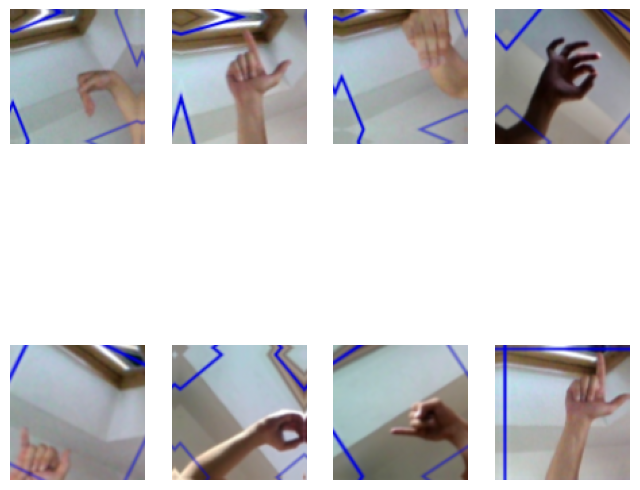

In [38]:
# Displaying sample images from the augmented dataset
import matplotlib.pyplot as plt

for images, labels in train_ds.take(1):
    plt.figure(figsize=(8, 8))  
    
    # Showing 8 images from the batch
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)  
        plt.imshow(images[i].numpy())
        plt.axis("off")
    plt.show()

In [39]:
# Creating sequence datasets of fixed-length image sequences with corresponding labels for training,
# validation, and testing, optimized with batching and prefetching.

def make_sequence_dataset(dataset, sequence_length=5, image_height=100, image_width=100):
    import tensorflow as tf
    dataset = dataset.unbatch()

    windows = dataset.window(sequence_length, shift=sequence_length, drop_remainder=True)

    def batch_window(images, labels):
        return tf.data.Dataset.zip((images.batch(sequence_length), labels.batch(sequence_length)))

    flat_dataset = windows.flat_map(batch_window)

    def map_fn(images, labels):
        
       
        images = tf.cast(images, tf.float32)
        images = tf.map_fn(lambda img: tf.image.resize(img, [image_height, image_width]), images)
        images.set_shape([sequence_length, image_height, image_width, 3])
        label = tf.cast(labels[-1], tf.int32)  # Use last label as target
        return images, label

    return flat_dataset.map(map_fn, num_parallel_calls=tf.data.AUTOTUNE)

batch_size = 8
train_seq_ds = make_sequence_dataset(train_ds, sequence_length=5, image_height=100, image_width=100) \
    .batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_seq_ds = make_sequence_dataset(val_ds, sequence_length=5, image_height=100, image_width=100) \
    .batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_seq_ds = make_sequence_dataset(test_ds, sequence_length=5, image_height=100, image_width=100) \
    .batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [40]:
# CNN feature extractor that turns 100×100 RGB images into 256-dim feature vectors
import tensorflow as tf
from tensorflow.keras import layers, models

num_classes = 29
input_shape = (100, 100, 3)

def create_cnn_feature_extractor(input_shape):
    model = models.Sequential([
        layers.InputLayer(input_shape=input_shape),

        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),

        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
    ])
    return model

cnn_feature_extractor = create_cnn_feature_extractor(input_shape)
cnn_feature_extractor.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 100, 100, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 50, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 25, 25, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 25, 25, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 127,168 (496.75 KB)

 Trainable params: 126,720 (495.00 KB)

 Non-trainable params: 448 (1.75 KB)

In [24]:
# CNN-LSTM model that learns spatial and temporal patterns to classify  image sequences.
from tensorflow.keras import layers, models

sequence_length = 5            
num_classes = 29               

cnn_feature_extractor = create_cnn_feature_extractor((100, 100, 3))

sequence_input = layers.Input(shape=(sequence_length, 100, 100, 3))

cnn_features = layers.TimeDistributed(cnn_feature_extractor)(sequence_input)

#LSTM layers
x = layers.LSTM(128, return_sequences=True)(cnn_features)
x = layers.LSTM(128)(x)  
output = layers.Dense(num_classes, activation='softmax')(x)

# Building model
model = models.Model(inputs=sequence_input, outputs=output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 5, 100, 100, 3) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 5, 256)         │       127,168 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 5, 128)         │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 29)             │         3,741 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 459,613 (1.75 MB)

 Trainable params: 459,165 (1.75 MB)

 Non-trainable params: 448 (1.75 KB)

In [25]:
# Veryfing the shape of image sequences and labels from the training dataset.
for img_seq, lbl in train_seq_ds.take(1):
    print("Images shape:", img_seq.shape)
    print("Label shape:", lbl.shape)

Images shape: (8, 5, 100, 100, 3)
Label shape: (8,)


In [26]:
# Training the model 
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',       
    patience=5,               
    restore_best_weights=True 
)

history = model.fit(
    train_seq_ds,
    validation_data=val_seq_ds,
    epochs=50,                
    verbose=1,
    callbacks=[early_stopping] 
)

Epoch 1/50
   1740/Unknown 123s 67ms/step - accuracy: 0.0463 - loss: 3.3197

/home/rama/anaconda3/envs/py310/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1740/1740 ━━━━━━━━━━━━━━━━━━━━ 161s 88ms/step - accuracy: 0.0670 - loss: 3.2000 - val_accuracy: 0.0575 - val_loss: 3.6013
Epoch 2/50


2025-10-12 10:18:09.123125: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12255617976895930074


1739/1740 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.1446 - loss: 2.7967

2025-10-12 10:21:14.149704: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-10-12 10:21:14.149785: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10689995639302441107
2025-10-12 10:21:14.149789: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 14134316495342073086
2025-10-12 10:21:14.149824: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15379074961259050476
2025-10-12 10:21:14.149880: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11318048105450943711


1740/1740 ━━━━━━━━━━━━━━━━━━━━ 214s 86ms/step - accuracy: 0.1595 - loss: 2.7226 - val_accuracy: 0.1546 - val_loss: 2.8053
Epoch 3/50


2025-10-12 10:21:43.118343: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8418513919859917257
2025-10-12 10:21:43.118381: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10857280316319512742
2025-10-12 10:21:43.118386: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12255617976895930074


1740/1740 ━━━━━━━━━━━━━━━━━━━━ 411s 236ms/step - accuracy: 0.2312 - loss: 2.4240 - val_accuracy: 0.3328 - val_loss: 2.0077
Epoch 4/50
1740/1740 ━━━━━━━━━━━━━━━━━━━━ 534s 306ms/step - accuracy: 0.3199 - loss: 2.1101 - val_accuracy: 0.3443 - val_loss: 2.0198
Epoch 5/50
1740/1740 ━━━━━━━━━━━━━━━━━━━━ 532s 305ms/step - accuracy: 0.3802 - loss: 1.8746 - val_accuracy: 0.4724 - val_loss: 1.4874
Epoch 6/50
1740/1740 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.4150 - loss: 1.7350

2025-10-12 10:50:41.032646: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1740/1740 ━━━━━━━━━━━━━━━━━━━━ 504s 289ms/step - accuracy: 0.4276 - loss: 1.6917 - val_accuracy: 0.5167 - val_loss: 1.3414
Epoch 7/50
1740/1740 ━━━━━━━━━━━━━━━━━━━━ 426s 245ms/step - accuracy: 0.4710 - loss: 1.5476 - val_accuracy: 0.5667 - val_loss: 1.1680
Epoch 8/50


2025-10-12 11:01:49.572965: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8418513919859917257
2025-10-12 11:01:49.573017: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 554413747889516511
2025-10-12 11:01:49.573026: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10857280316319512742
2025-10-12 11:01:49.573029: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12255617976895930074


1740/1740 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.4974 - loss: 1.4582

2025-10-12 11:03:49.601467: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 14134316495342073086
2025-10-12 11:03:49.601519: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15379074961259050476
2025-10-12 11:03:49.601534: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10689995639302441107
2025-10-12 11:03:49.601546: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11318048105450943711


1740/1740 ━━━━━━━━━━━━━━━━━━━━ 148s 85ms/step - accuracy: 0.5022 - loss: 1.4325 - val_accuracy: 0.6362 - val_loss: 1.0588
Epoch 9/50


2025-10-12 11:04:17.765824: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8418513919859917257
2025-10-12 11:04:17.765860: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 554413747889516511
2025-10-12 11:04:17.765866: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10857280316319512742
2025-10-12 11:04:17.765869: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12255617976895930074


1740/1740 ━━━━━━━━━━━━━━━━━━━━ 467s 267ms/step - accuracy: 0.5491 - loss: 1.3104 - val_accuracy: 0.5282 - val_loss: 1.3850
Epoch 10/50
1740/1740 ━━━━━━━━━━━━━━━━━━━━ 481s 276ms/step - accuracy: 0.5692 - loss: 1.2340 - val_accuracy: 0.6793 - val_loss: 0.9487
Epoch 11/50
1740/1740 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.5803 - loss: 1.1946

2025-10-12 11:23:04.919383: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 14134316495342073086
2025-10-12 11:23:04.919417: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15379074961259050476
2025-10-12 11:23:04.919419: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6296597977463959518
2025-10-12 11:23:04.919422: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10689995639302441107
2025-10-12 11:23:04.919425: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11318048105450943711


1740/1740 ━━━━━━━━━━━━━━━━━━━━ 205s 117ms/step - accuracy: 0.5852 - loss: 1.1669 - val_accuracy: 0.7241 - val_loss: 0.7624
Epoch 12/50
1740/1740 ━━━━━━━━━━━━━━━━━━━━ 386s 222ms/step - accuracy: 0.6132 - loss: 1.0944 - val_accuracy: 0.8029 - val_loss: 0.6022
Epoch 13/50
1740/1740 ━━━━━━━━━━━━━━━━━━━━ 518s 298ms/step - accuracy: 0.6369 - loss: 1.0382 - val_accuracy: 0.7023 - val_loss: 0.8326
Epoch 14/50
1740/1740 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.6443 - loss: 0.9859

2025-10-12 11:42:59.160245: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1740/1740 ━━━━━━━━━━━━━━━━━━━━ 485s 279ms/step - accuracy: 0.6500 - loss: 0.9851 - val_accuracy: 0.6943 - val_loss: 0.8276
Epoch 15/50
1740/1740 ━━━━━━━━━━━━━━━━━━━━ 502s 289ms/step - accuracy: 0.6763 - loss: 0.9189 - val_accuracy: 0.6776 - val_loss: 0.8907
Epoch 16/50
1740/1740 ━━━━━━━━━━━━━━━━━━━━ 350s 201ms/step - accuracy: 0.6885 - loss: 0.9127 - val_accuracy: 0.7569 - val_loss: 0.7070
Epoch 17/50


2025-10-12 12:00:52.493216: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8418513919859917257
2025-10-12 12:00:52.493270: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 554413747889516511
2025-10-12 12:00:52.493280: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10857280316319512742
2025-10-12 12:00:52.493283: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12255617976895930074


1740/1740 ━━━━━━━━━━━━━━━━━━━━ 156s 89ms/step - accuracy: 0.7027 - loss: 0.8563 - val_accuracy: 0.8494 - val_loss: 0.4282
Epoch 18/50


2025-10-12 12:03:28.219263: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8418513919859917257
2025-10-12 12:03:28.219310: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 554413747889516511
2025-10-12 12:03:28.219318: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10857280316319512742
2025-10-12 12:03:28.219322: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12255617976895930074


1740/1740 ━━━━━━━━━━━━━━━━━━━━ 155s 89ms/step - accuracy: 0.7154 - loss: 0.8315 - val_accuracy: 0.6902 - val_loss: 0.9364
Epoch 19/50
1740/1740 ━━━━━━━━━━━━━━━━━━━━ 156s 89ms/step - accuracy: 0.7256 - loss: 0.7908 - val_accuracy: 0.8236 - val_loss: 0.5168
Epoch 20/50


2025-10-12 12:08:38.249141: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8418513919859917257
2025-10-12 12:08:38.249183: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 554413747889516511
2025-10-12 12:08:38.249190: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10857280316319512742
2025-10-12 12:08:38.249193: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12255617976895930074


1740/1740 ━━━━━━━━━━━━━━━━━━━━ 158s 91ms/step - accuracy: 0.7453 - loss: 0.7501 - val_accuracy: 0.5954 - val_loss: 1.4534
Epoch 21/50
1739/1740 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.7524 - loss: 0.7088

2025-10-12 12:14:20.120707: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10689995639302441107
2025-10-12 12:14:20.120748: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11318048105450943711
2025-10-12 12:14:20.120757: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15379074961259050476


1740/1740 ━━━━━━━━━━━━━━━━━━━━ 213s 86ms/step - accuracy: 0.7517 - loss: 0.7169 - val_accuracy: 0.7069 - val_loss: 0.8682
Epoch 22/50


2025-10-12 12:14:49.797003: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8418513919859917257
2025-10-12 12:14:49.797080: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10857280316319512742
2025-10-12 12:14:49.797095: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12255617976895930074


1740/1740 ━━━━━━━━━━━━━━━━━━━━ 152s 87ms/step - accuracy: 0.7552 - loss: 0.7060 - val_accuracy: 0.6529 - val_loss: 1.0968


2025-10-12 12:17:21.506756: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8418513919859917257
2025-10-12 12:17:21.506792: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 554413747889516511
2025-10-12 12:17:21.506799: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10857280316319512742
2025-10-12 12:17:21.506802: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12255617976895930074


The model shows steady improvement, reaching about 75.5% accuracy and significantly reduced loss after 22 epochs, with validation metrics indicating good generalization

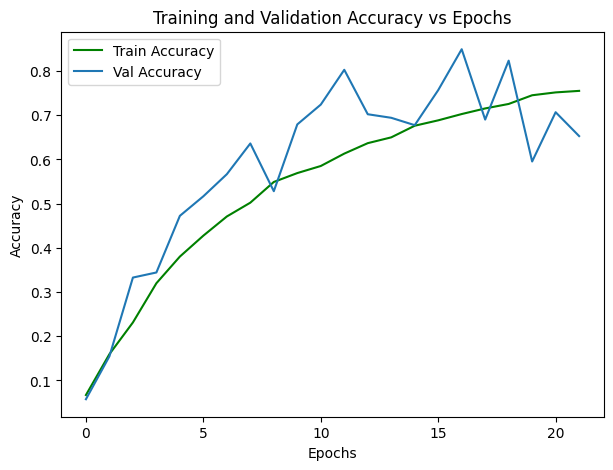

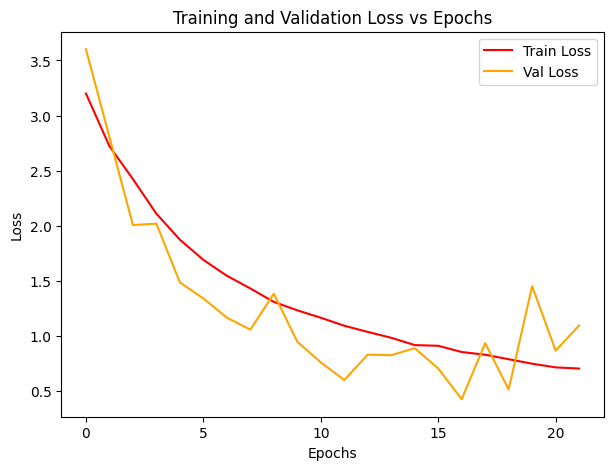

In [28]:
# Plotting the optimization curves
import matplotlib.pyplot as plt

# Plotting Training and Validation Accuracy
plt.figure(figsize=(7, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs Epochs')
plt.legend()
plt.show()

# Plotting Training and Validation Loss
plt.figure(figsize=(7, 5))
plt.plot(history.history['loss'], label='Train Loss', color='red')
plt.plot(history.history['val_loss'], label='Val Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs Epochs')
plt.legend()
plt.show()

The model shows consistent learning, with accuracy rising above 70% and losses dropping below 1 for both training and validation; some fluctuation is present, but overall results indicate strong generalization and effective training.The model achieves good learning, with accuracy climbing above 70% and losses dropping sharply below 1 for both training and validation, showing strong generalization and effective training with slight fluctuations in validation performance

In [29]:
# Evaluating on the test sequence dataset
test_loss, test_accuracy = model.evaluate(test_seq_ds, verbose=1)

print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Loss: {test_loss:.4f}')

218/218 ━━━━━━━━━━━━━━━━━━━━ 29s 16ms/step - accuracy: 0.8592 - loss: 0.4066
Test Accuracy: 0.8592
Test Loss: 0.4066


2025-10-12 12:54:09.014871: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12255617976895930074


Model evaluation on the test dataset shows an accuracy of ~86.0% and a loss of ~0.41%, indicating good generalization on unseen sequences.

In [31]:
#Saving the model, if needed for future use.
model.save('cnn_lstm_seq_model.keras')

In [75]:
!pip install scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 1.1 MB/s  0:00:09m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.7/37.7 MB 442.2 kB/s  0:00:54m0:00:0100:03
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [scikit-learn] [scikit-learn]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━

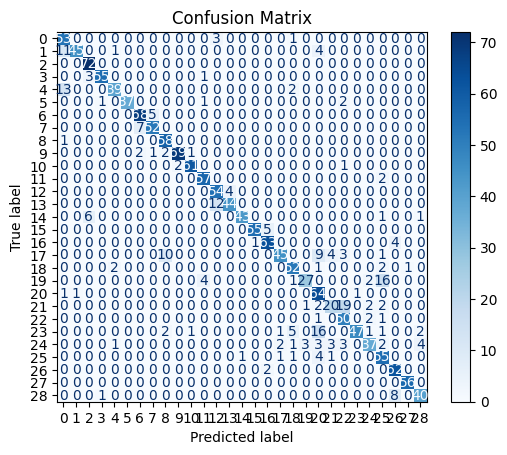

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_true = []
y_pred = []

for x_batch, y_batch in test_seq_ds:
    
    preds = model.predict(x_batch)
    
    pred_classes = np.argmax(preds, axis=1)
    y_pred.extend(pred_classes)
    y_true.extend(y_batch.numpy() if hasattr(y_batch, 'numpy') else y_batch)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Generating classification report
report = classification_report(y_true, y_pred, digits=4)
print("Classification Report:\n", report)

# Computing confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plotting confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

The classification report and confusion matrix show the model achieves around 85% accuracy. Most classes have good precision and recall, reflected by a strong diagonal, while a few lower-scoring classes indicate minor misclassifications or class imbalance. Overall, the model performs well but could improve on challenging or underrepresented classes.

Updating the CNN-LSTM model by adding Dropout after each LSTM layer and lowering the Adam learning rate to 0.0005 (from default 0.001) to improve generalization and potentially achieve better performance.

In [41]:
from tensorflow.keras import layers, models
from tensorflow.keras import optimizers

# Number of frames in each sequence:
sequence_length = 5            
num_classes = 29               

cnn_feature_extractor = create_cnn_feature_extractor((100, 100, 3))

sequence_input = layers.Input(shape=(sequence_length, 100, 100, 3))

cnn_features = layers.TimeDistributed(cnn_feature_extractor)(sequence_input)

# LSTM layers with Dropout
x = layers.LSTM(128, return_sequences=True)(cnn_features)
x = layers.Dropout(0.3)(x) 
x = layers.LSTM(128)(x)
x = layers.Dropout(0.3)(x)  

output = layers.Dense(num_classes, activation='softmax')(x)

# Compiling the model1
model1 = models.Model(inputs=sequence_input, outputs=output)

# Settting Adam optimizer with learning rate 0.0005
adam_optimizer = optimizers.Adam(learning_rate=0.0005)

model1.compile(optimizer=adam_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model1.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 5, 100, 100, 3) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 5, 256)         │       127,168 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 5, 128)         │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 29)             │         3,741 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 459,613 (1.75 MB)

 Trainable params: 459,165 (1.75 MB)

 Non-trainable params: 448 (1.75 KB)

In [42]:
# Training the model1
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',      
    patience=5,               
    restore_best_weights=True 
)

history1 = model1.fit(
    train_seq_ds,
    validation_data=val_seq_ds,
    epochs=50,               
    verbose=1,
    callbacks=[early_stopping] 
)

Epoch 1/50
1740/1740 ━━━━━━━━━━━━━━━━━━━━ 268s 152ms/step - accuracy: 0.0552 - loss: 3.2908 - val_accuracy: 0.0822 - val_loss: 3.0076
Epoch 2/50


2025-10-12 14:44:52.622338: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10857280316319512742
2025-10-12 14:44:52.622378: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12255617976895930074


1740/1740 ━━━━━━━━━━━━━━━━━━━━ 253s 137ms/step - accuracy: 0.1103 - loss: 2.9389 - val_accuracy: 0.1586 - val_loss: 2.7964
Epoch 3/50


2025-10-12 14:49:08.608075: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8418513919859917257
2025-10-12 14:49:08.608118: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 554413747889516511
2025-10-12 14:49:08.608126: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10857280316319512742
2025-10-12 14:49:08.608130: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12255617976895930074


1740/1740 ━━━━━━━━━━━━━━━━━━━━ 309s 152ms/step - accuracy: 0.1742 - loss: 2.6514 - val_accuracy: 0.1621 - val_loss: 2.7004
Epoch 4/50


2025-10-12 14:54:17.748706: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10857280316319512742
2025-10-12 14:54:17.748743: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12255617976895930074


1740/1740 ━━━━━━━━━━━━━━━━━━━━ 246s 141ms/step - accuracy: 0.2287 - loss: 2.4292 - val_accuracy: 0.1874 - val_loss: 2.7563
Epoch 5/50


2025-10-12 14:58:23.485914: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10857280316319512742
2025-10-12 14:58:23.485952: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12255617976895930074


1740/1740 ━━━━━━━━━━━━━━━━━━━━ 536s 308ms/step - accuracy: 0.2931 - loss: 2.2140 - val_accuracy: 0.4161 - val_loss: 1.7765
Epoch 6/50


2025-10-12 15:07:19.451026: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10857280316319512742
2025-10-12 15:07:19.451098: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12255617976895930074


1740/1740 ━━━━━━━━━━━━━━━━━━━━ 201s 115ms/step - accuracy: 0.3483 - loss: 1.9925 - val_accuracy: 0.4069 - val_loss: 1.7402
Epoch 7/50


2025-10-12 15:10:40.737958: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8418513919859917257
2025-10-12 15:10:40.737998: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10857280316319512742
2025-10-12 15:10:40.738002: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12255617976895930074


1740/1740 ━━━━━━━━━━━━━━━━━━━━ 458s 263ms/step - accuracy: 0.3968 - loss: 1.8049 - val_accuracy: 0.5339 - val_loss: 1.3434
Epoch 8/50


2025-10-12 15:18:18.522500: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10857280316319512742
2025-10-12 15:18:18.522570: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12255617976895930074


1740/1740 ━━━━━━━━━━━━━━━━━━━━ 259s 149ms/step - accuracy: 0.4411 - loss: 1.6466 - val_accuracy: 0.4540 - val_loss: 1.5097
Epoch 9/50


2025-10-12 15:22:37.541848: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10857280316319512742
2025-10-12 15:22:37.541894: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12255617976895930074


1740/1740 ━━━━━━━━━━━━━━━━━━━━ 199s 114ms/step - accuracy: 0.4747 - loss: 1.5230 - val_accuracy: 0.6259 - val_loss: 1.0086
Epoch 10/50


2025-10-12 15:25:56.042236: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8418513919859917257
2025-10-12 15:25:56.042348: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 554413747889516511
2025-10-12 15:25:56.042363: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10857280316319512742
2025-10-12 15:25:56.042368: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12255617976895930074


1740/1740 ━━━━━━━━━━━━━━━━━━━━ 164s 94ms/step - accuracy: 0.5004 - loss: 1.4298 - val_accuracy: 0.6684 - val_loss: 0.9229
Epoch 11/50


2025-10-12 15:28:40.096772: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10857280316319512742
2025-10-12 15:28:40.096818: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12255617976895930074


1740/1740 ━━━━━━━━━━━━━━━━━━━━ 166s 95ms/step - accuracy: 0.5240 - loss: 1.3638 - val_accuracy: 0.6080 - val_loss: 1.0513
Epoch 12/50


2025-10-12 15:31:26.264566: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8418513919859917257
2025-10-12 15:31:26.264615: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10857280316319512742
2025-10-12 15:31:26.264621: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12255617976895930074


1740/1740 ━━━━━━━━━━━━━━━━━━━━ 295s 169ms/step - accuracy: 0.5547 - loss: 1.2753 - val_accuracy: 0.6333 - val_loss: 1.0318
Epoch 13/50


2025-10-12 15:36:21.107713: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10857280316319512742
2025-10-12 15:36:21.107753: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12255617976895930074


1740/1740 ━━━━━━━━━━━━━━━━━━━━ 230s 132ms/step - accuracy: 0.5781 - loss: 1.2109 - val_accuracy: 0.5753 - val_loss: 1.1986
Epoch 14/50


2025-10-12 15:40:10.983822: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10857280316319512742
2025-10-12 15:40:10.983910: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12255617976895930074


1740/1740 ━━━━━━━━━━━━━━━━━━━━ 535s 307ms/step - accuracy: 0.6021 - loss: 1.1526 - val_accuracy: 0.6833 - val_loss: 0.8852
Epoch 15/50


2025-10-12 15:49:06.270188: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10857280316319512742
2025-10-12 15:49:06.270301: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12255617976895930074


1740/1740 ━━━━━━━━━━━━━━━━━━━━ 524s 301ms/step - accuracy: 0.6184 - loss: 1.0937 - val_accuracy: 0.7672 - val_loss: 0.6808
Epoch 16/50


2025-10-12 15:57:50.265699: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10857280316319512742
2025-10-12 15:57:50.265779: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12255617976895930074


1740/1740 ━━━━━━━━━━━━━━━━━━━━ 470s 270ms/step - accuracy: 0.6389 - loss: 1.0435 - val_accuracy: 0.8017 - val_loss: 0.6151
Epoch 17/50


2025-10-12 16:05:40.021443: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12255617976895930074


1740/1740 ━━━━━━━━━━━━━━━━━━━━ 162s 93ms/step - accuracy: 0.6471 - loss: 0.9985 - val_accuracy: 0.5678 - val_loss: 1.3809
Epoch 18/50


2025-10-12 16:08:22.340845: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8418513919859917257
2025-10-12 16:08:22.340893: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 554413747889516511
2025-10-12 16:08:22.340902: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10857280316319512742
2025-10-12 16:08:22.340905: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12255617976895930074


1740/1740 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.6700 - loss: 0.9479

2025-10-12 16:11:37.272998: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1842185531962968191
2025-10-12 16:11:37.273058: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3562458582915957737


1740/1740 ━━━━━━━━━━━━━━━━━━━━ 224s 128ms/step - accuracy: 0.6726 - loss: 0.9440 - val_accuracy: 0.7839 - val_loss: 0.5878
Epoch 19/50


2025-10-12 16:12:05.922602: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10857280316319512742
2025-10-12 16:12:05.922639: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12255617976895930074


1740/1740 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.6784 - loss: 0.9175

2025-10-12 16:14:15.128715: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 4037979320996626470
2025-10-12 16:14:15.128745: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1842185531962968191
2025-10-12 16:14:15.129953: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3562458582915957737
2025-10-12 16:14:15.129966: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15815575691761294615
2025-10-12 16:14:15.129968: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 16394004038378063241
2025-10-12 16:14:15.130117: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 4405199982991080160
2025-10-12 16:14:15.130140: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send i

1740/1740 ━━━━━━━━━━━━━━━━━━━━ 212s 122ms/step - accuracy: 0.6868 - loss: 0.8969 - val_accuracy: 0.8190 - val_loss: 0.4867
Epoch 20/50


2025-10-12 16:15:38.240406: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10857280316319512742
2025-10-12 16:15:38.240498: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12255617976895930074


1740/1740 ━━━━━━━━━━━━━━━━━━━━ 590s 337ms/step - accuracy: 0.6979 - loss: 0.8691 - val_accuracy: 0.7454 - val_loss: 0.6868
Epoch 21/50


2025-10-12 16:25:27.963903: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12255617976895930074


1740/1740 ━━━━━━━━━━━━━━━━━━━━ 331s 190ms/step - accuracy: 0.7055 - loss: 0.8489 - val_accuracy: 0.8736 - val_loss: 0.3701
Epoch 22/50


2025-10-12 16:30:59.449227: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8418513919859917257
2025-10-12 16:30:59.449282: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10857280316319512742
2025-10-12 16:30:59.449308: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12255617976895930074


1740/1740 ━━━━━━━━━━━━━━━━━━━━ 156s 90ms/step - accuracy: 0.7193 - loss: 0.8119 - val_accuracy: 0.8385 - val_loss: 0.4981
Epoch 23/50


2025-10-12 16:33:35.539673: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10857280316319512742
2025-10-12 16:33:35.539713: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12255617976895930074


1740/1740 ━━━━━━━━━━━━━━━━━━━━ 495s 285ms/step - accuracy: 0.7310 - loss: 0.7888 - val_accuracy: 0.8057 - val_loss: 0.5703
Epoch 24/50


2025-10-12 16:41:50.810640: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8418513919859917257
2025-10-12 16:41:50.810734: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10857280316319512742
2025-10-12 16:41:50.810748: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12255617976895930074


1740/1740 ━━━━━━━━━━━━━━━━━━━━ 516s 296ms/step - accuracy: 0.7487 - loss: 0.7381 - val_accuracy: 0.8954 - val_loss: 0.3180
Epoch 25/50


2025-10-12 16:50:26.428826: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10857280316319512742
2025-10-12 16:50:26.428909: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12255617976895930074


1740/1740 ━━━━━━━━━━━━━━━━━━━━ 593s 324ms/step - accuracy: 0.7580 - loss: 0.7106 - val_accuracy: 0.8500 - val_loss: 0.4355
Epoch 26/50


2025-10-12 17:00:19.531511: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10857280316319512742
2025-10-12 17:00:19.531643: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12255617976895930074


1740/1740 ━━━━━━━━━━━━━━━━━━━━ 288s 165ms/step - accuracy: 0.7633 - loss: 0.7000 - val_accuracy: 0.7902 - val_loss: 0.6586
Epoch 27/50


2025-10-12 17:05:07.377812: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10857280316319512742
2025-10-12 17:05:07.377856: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12255617976895930074


1740/1740 ━━━━━━━━━━━━━━━━━━━━ 222s 127ms/step - accuracy: 0.7677 - loss: 0.6848 - val_accuracy: 0.9149 - val_loss: 0.2537
Epoch 28/50


2025-10-12 17:08:48.937317: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-10-12 17:08:48.937401: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10857280316319512742
2025-10-12 17:08:48.937413: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12255617976895930074


1740/1740 ━━━━━━━━━━━━━━━━━━━━ 522s 300ms/step - accuracy: 0.7693 - loss: 0.6675 - val_accuracy: 0.8184 - val_loss: 0.4970
Epoch 29/50


2025-10-12 17:17:30.558393: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10857280316319512742
2025-10-12 17:17:30.558475: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12255617976895930074


1740/1740 ━━━━━━━━━━━━━━━━━━━━ 495s 284ms/step - accuracy: 0.7821 - loss: 0.6462 - val_accuracy: 0.9328 - val_loss: 0.2108
Epoch 30/50


2025-10-12 17:25:45.313659: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8418513919859917257
2025-10-12 17:25:45.313742: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 554413747889516511
2025-10-12 17:25:45.313752: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10857280316319512742
2025-10-12 17:25:45.313756: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12255617976895930074


1740/1740 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.7903 - loss: 0.6239

2025-10-12 17:27:59.887668: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 10583831173389190256
2025-10-12 17:27:59.887704: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1842185531962968191
2025-10-12 17:27:59.887707: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 10651387942525769915
2025-10-12 17:27:59.887710: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3562458582915957737
2025-10-12 17:27:59.887712: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15815575691761294615


1740/1740 ━━━━━━━━━━━━━━━━━━━━ 167s 96ms/step - accuracy: 0.7911 - loss: 0.6200 - val_accuracy: 0.8925 - val_loss: 0.2919
Epoch 31/50


2025-10-12 17:28:32.517471: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8418513919859917257
2025-10-12 17:28:32.517502: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 554413747889516511
2025-10-12 17:28:32.517508: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10857280316319512742
2025-10-12 17:28:32.517510: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12255617976895930074


1740/1740 ━━━━━━━━━━━━━━━━━━━━ 164s 94ms/step - accuracy: 0.7925 - loss: 0.6134 - val_accuracy: 0.8822 - val_loss: 0.3033
Epoch 32/50


2025-10-12 17:31:16.423183: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8418513919859917257
2025-10-12 17:31:16.423213: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10857280316319512742
2025-10-12 17:31:16.423217: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12255617976895930074


1740/1740 ━━━━━━━━━━━━━━━━━━━━ 166s 96ms/step - accuracy: 0.7983 - loss: 0.5901 - val_accuracy: 0.8546 - val_loss: 0.3807
Epoch 33/50


2025-10-12 17:34:02.756153: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10857280316319512742
2025-10-12 17:34:02.756190: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12255617976895930074


1740/1740 ━━━━━━━━━━━━━━━━━━━━ 167s 96ms/step - accuracy: 0.8047 - loss: 0.5760 - val_accuracy: 0.9218 - val_loss: 0.2319
Epoch 34/50


2025-10-12 17:36:49.383528: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10857280316319512742
2025-10-12 17:36:49.383561: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12255617976895930074


1740/1740 ━━━━━━━━━━━━━━━━━━━━ 193s 111ms/step - accuracy: 0.8116 - loss: 0.5658 - val_accuracy: 0.8851 - val_loss: 0.3032


2025-10-12 17:40:02.866293: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10857280316319512742
2025-10-12 17:40:02.866336: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12255617976895930074


The model1 demonstrates steady progress, reaching around 80% accuracy and substantially lower loss after 34 epochs, with validation results confirming strong generalization and effective learning throughout training.

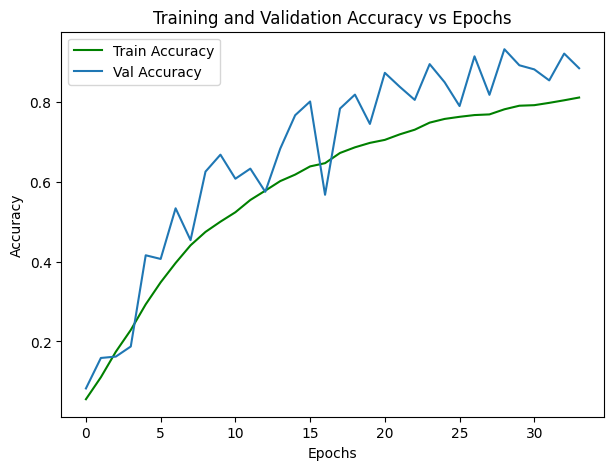

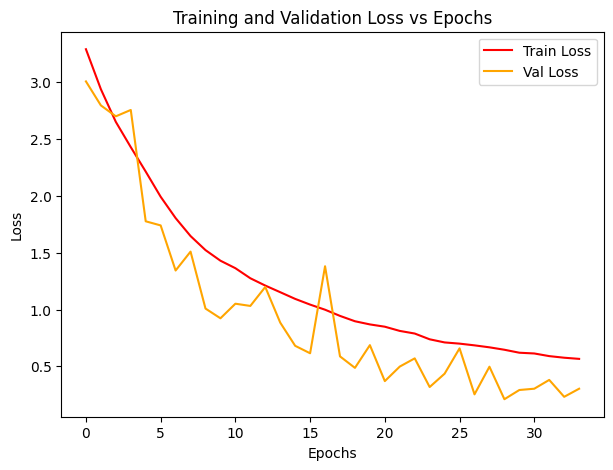

In [43]:
# Plotting the curves 
import matplotlib.pyplot as plt

# Plotting Training and Validation Accuracy
plt.figure(figsize=(7, 5))
plt.plot(history1.history['accuracy'], label='Train Accuracy', color='green')
plt.plot(history1.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs Epochs')
plt.legend()
plt.show()

# Plotting Training and Validation Loss
plt.figure(figsize=(7, 5))
plt.plot(history1.history['loss'], label='Train Loss', color='red')
plt.plot(history1.history['val_loss'], label='Val Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs Epochs')
plt.legend()
plt.show()

The model1 shows consistent learning, with accuracy rising well above 80% and losses dropping below 1 for training and validation; slight fluctuations are present, but overall results demonstrate strong generalization and highly effective training.

In [44]:
# Evaluating on the test sequence dataset
test_loss, test_accuracy = model1.evaluate(test_seq_ds, verbose=1)

print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Loss: {test_loss:.4f}')

218/218 ━━━━━━━━━━━━━━━━━━━━ 36s 19ms/step - accuracy: 0.9241 - loss: 0.2188
Test Accuracy: 0.9241
Test Loss: 0.2188


2025-10-12 17:47:17.083181: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10857280316319512742
2025-10-12 17:47:17.083212: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12255617976895930074


Model1 demonstrates excellent performance on the test set, achieving a high accuracy of 92.4% and a very low loss of 0.22, which confirms strong predictive power and effective generalization to unseen data.

In [45]:
# Saving the model1,if needed for future use.
model1.save('cnn_lstm_seq_model1.keras')

FINAL CONCLUSION :

After implementing dropout and setting the learning rate to 0.0005, the model’s performance improved dramatically compared to the initial configuration: accuracy now exceeds 80% on training and validation sets, and the test accuracy reached 92.41% with a very low test loss of 0.2188. This emphasizes how tuning hyperparameters like dropout and learning rate leads to better learning and strong generalization across all evaluation sets.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━

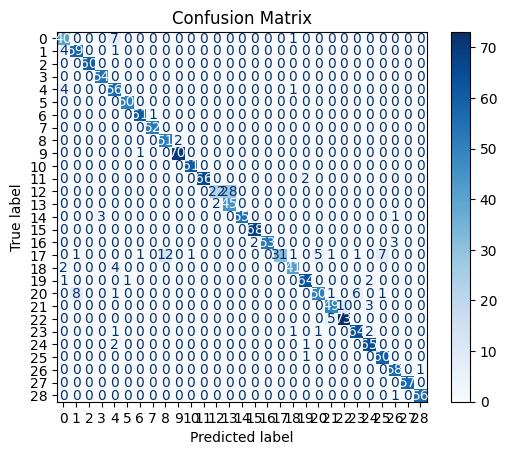

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


y_true = []
y_pred = []

for x_batch, y_batch in test_seq_ds:
    preds = model1.predict(x_batch)
    
    pred_classes = np.argmax(preds, axis=1)
    y_pred.extend(pred_classes)
    y_true.extend(y_batch.numpy() if hasattr(y_batch, 'numpy') else y_batch)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Generating classification report
report = classification_report(y_true, y_pred, digits=4)
print("Classification Report:\n", report)

# Computing confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plotting confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


The classification report and confusion matrix show that the model achieves high precision, recall, and F1-scores for most classes, with an overall accuracy of 91.4%. Most predictions are correctly placed along the diagonal of the confusion matrix, indicating reliable performance and good class separation. Minor drops in specific classes suggest possible data imbalance or similarity in a few cases, but the model delivers strong, balanced results across all categories.